# CrateRover motor sizing

One of the most important parts of the rover is the drive system. The required power and torgue necessary to move
the rover largely determines the size of the motors and batteries. Additionally the sizing of the drive system
will determine a large part of the weight of the rover.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from robot_functions import *
from crate_rover_specs import *

rover_specs = RoverSpecification()
rover = Rover(rover_specs)

The following calculations are based on the following [PhD thesis](https://www.chalmers.se/SiteCollectionDocuments/Energi%20och%20milj%C3%B6/Elteknik/EmmaGrunditz_PhDthesis_lowrez.pdf).

    Design and Assessment of Battery Electric Vehicle Powertrain, with Respect to Performance, Energy Consumption and Electric Motor Thermal Capability
    Emma Arfa Grunditz
    Department of Energy and Environment
    Division of Electric Power Engineering
    Chalmers University of Technology
    Gotenborg, Sweden 2016

The first part of the drive system calculation is to determine the following two parameters:

* The minimum torgue required to allow the rover to drive up the minimum required slope.
* The minimum power required to allow the rover to achieved the required transport velocity.

The following graphs provide insight in the wheel force and wheel power for different velocities and slope angles.

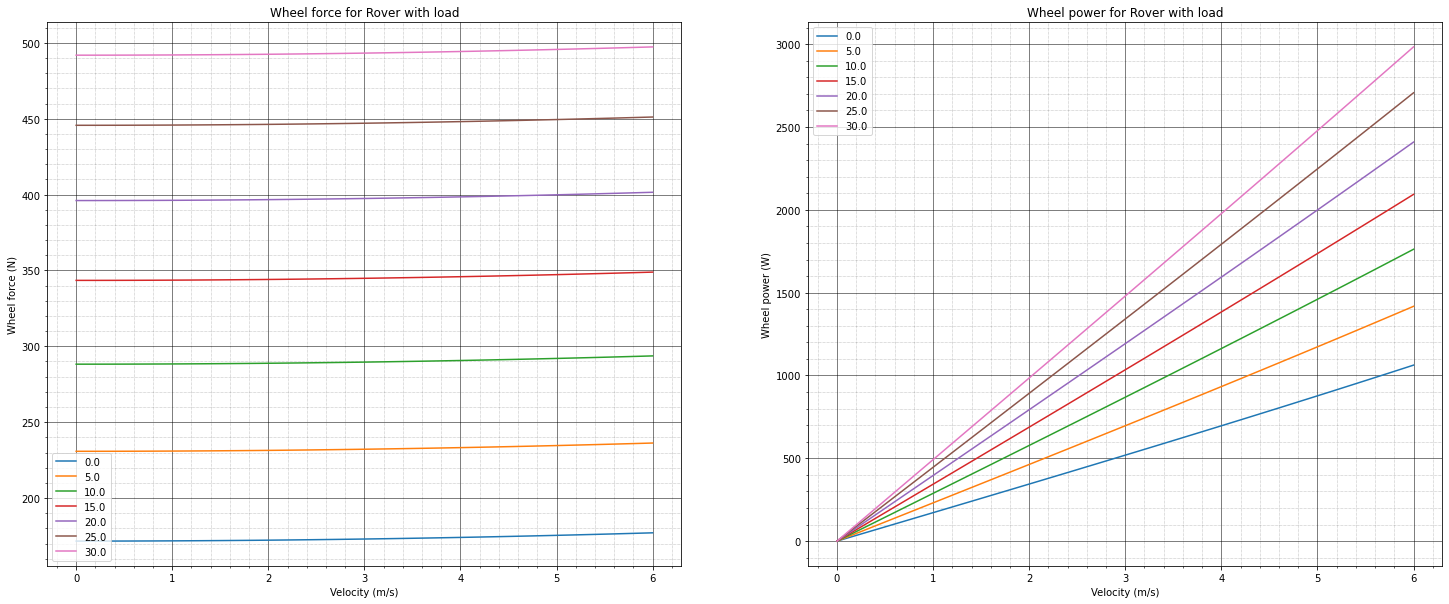

In [7]:
# Calculate wheel forces and wheel power
wheel_forces_without_load = []
wheel_power_without_load = []

wheel_forces_with_load = []
wheel_power_with_load = []
columns = ['velocity']

velocity_step = 0.1
maximum_velocity = rover_specs.performance.maximum_velocity_on_flat_ground() * 3 + velocity_step
for velocity in np.arange(0.0, maximum_velocity,
                          velocity_step):
    
    forces_without_load = [ velocity ]
    powers_without_load = [ velocity ]

    forces_with_load = [ velocity ]
    powers_with_load = [ velocity ]

    slope_step = 5.0
    for slope in np.arange(0.0, rover_specs.performance.maximum_slope_angle_without_load() + slope_step,
                           slope_step):

        slope_as_text = str(slope)
        if slope_as_text not in columns:
            columns.append(slope_as_text)

        wheel_force_with_load, power_with_load = rover.wheel_force_and_power_with_cargo(
            velocity,
            slope)

        forces_with_load.append(wheel_force_with_load)
        powers_with_load.append(power_with_load)

    wheel_forces_without_load.append(forces_without_load)
    wheel_power_without_load.append(powers_without_load)

    wheel_forces_with_load.append(forces_with_load)
    wheel_power_with_load.append(powers_with_load)

force_without_load_df = pd.DataFrame(wheel_forces_without_load, columns=columns)
power_without_load_df = pd.DataFrame(wheel_power_without_load, columns=columns)

force_with_load_df = pd.DataFrame(wheel_forces_with_load, columns=columns)
power_with_load_df = pd.DataFrame(wheel_power_with_load, columns=columns)

fig, ax_group = plt.subplots(2, 2, figsize=(25, 10), sharex=False)

# unpack all the axes subplots
axs = ax_group.ravel()

force_without_load_df.plot(x='velocity', ax=axs[0])
axs[0].set_title('Wheel force for Rover without load')
axs[0].set_xlabel('Velocity (m/s)')
axs[0].set_ylabel('Wheel force (N)')
axs[0].set_axisbelow(True)
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

power_without_load_df.plot(x='velocity', ax=axs[1])
axs[1].set_title('Wheel power for Rover without load')
axs[1].set_xlabel('Velocity (m/s)')
axs[1].set_ylabel('Wheel power (W)')
axs[1].set_axisbelow(True)
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')


force_with_load_df.plot(x='velocity', ax=axs[2])
axs[2].set_title('Wheel force for Rover with load')
axs[2].set_xlabel('Velocity (m/s)')
axs[2].set_ylabel('Wheel force (N)')
axs[2].set_axisbelow(True)
axs[2].minorticks_on()
axs[2].grid(which='major', linestyle='-', linewidth='0.5', color='black')
axs[2].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)

power_with_load_df.plot(x='velocity', ax=axs[3])
axs[3].set_title('Wheel power for Rover with load')
axs[3].set_xlabel('Velocity (m/s)')
axs[3].set_ylabel('Wheel power (W)')
axs[3].set_axisbelow(True)
axs[3].minorticks_on()
axs[3].grid(which='major', linestyle='-', linewidth='0.5', color='black')
axs[3].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)

plt.show()

Once the force and power curves for different velocities and slope angles have been created the next step is to 
determine the velocity-force and velocity-acceleration diagrams. From these diagrams it is possible to determine the
characteristics of the rover engines.

In [95]:
# Determine minimum power and force requirements
minimum_power_required = power_with_load_df[str(rover_specs.performance.maximum_slope_angle_with_maximum_load())][rover_specs.performance.maximum_velocity_on_sloped_ground() * (1 / velocity_step)]

force_at_max_slope = minimum_power_required / rover_specs.performance.maximum_velocity_on_sloped_ground()
torque_at_max_slope = force_at_max_slope * rover_specs.chassis.wheel.radius_in_meters

velocity_max_on_flat_ground = rover.velocity_for_slope_and_power(
    minimum_power_required, 
    rover.frontal_surface(),
    rover.weight_with_cargo_in_kg(),
    0.0)

force_at_zero_slope = minimum_power_required / velocity_max_on_flat_ground
torque_at_zero_slope = force_at_zero_slope * rover_specs.chassis.wheel.radius_in_meters

# Calculate motor torque, motor speed and motor power
torque_at_zero_slope_per_motor = torque_at_zero_slope / rover_specs.chassis.number_of_wheels
maximum_rotation_speed = velocity_max_on_flat_ground / (2.0 * math.pi * rover_specs.chassis.wheel.radius_in_meters)
power_at_zero_slope_per_motor = torque_at_zero_slope_per_motor * maximum_rotation_speed * 2.0 * math.pi

torque_at_max_slope_per_motor = torque_at_max_slope / rover_specs.chassis.number_of_wheels
maximum_slope_rotation_speed = rover_specs.performance.maximum_velocity_on_sloped_ground() / (2.0 * math.pi * rover_specs.chassis.wheel.radius_in_meters)
power_at_max_slope_per_motor = torque_at_max_slope_per_motor * maximum_slope_rotation_speed * 2.0 * math.pi

motor_requirements = pd.DataFrame(
    [
        [ 0.0, maximum_rotation_speed * 60.0, torque_at_zero_slope_per_motor, power_at_zero_slope_per_motor ],
        [ rover_specs.performance.maximum_slope_angle_with_maximum_load(), maximum_slope_rotation_speed * 60.0, torque_at_max_slope_per_motor, power_at_max_slope_per_motor ]
    ], 
    columns=['slope (degrees)', 'rotation speed (RPM)', 'torque - ideal (Nm)', 'power - ideal (W)'])

# Use gearing efficiencies to figure out how much power the motor needs to have

# Guessing to have 4 gears
# 1) Motor 90 degrees to vertical drive shaft
# 2) vertical drive shaft to horizontal at top of swerve module
# 3) horizontal drive shaft to vertical drive shaft at side of swerve module
# 4) Drive shaft to wheel
#
# Assume 95% efficiency for each gear

drive_efficiency = math.pow(0.95, 4)
motor_requirements['torque - friction (Nm)'] = motor_requirements['torque - ideal (Nm)'] / drive_efficiency
motor_requirements['power - friction (W)'] = motor_requirements['power - ideal (W)'] / drive_efficiency

gear_ratio = 16.0

motor_geared_requirements = pd.DataFrame(
    [
        [ 0.0, maximum_rotation_speed * 60.0 * gear_ratio, motor_requirements['torque - friction (Nm)'][0] / gear_ratio, motor_requirements['power - friction (W)'][0] ],
        [ rover_specs.performance.maximum_slope_angle_with_maximum_load(), maximum_slope_rotation_speed * 60.0 * gear_ratio, motor_requirements['torque - friction (Nm)'][1] / gear_ratio, motor_requirements['power - friction (W)'][1] ]
    ], 
    columns=['slope (degrees)', 'rotation speed (RPM)', 'torque - geared (Nm)', 'power - geared (W)'])

motor_geared_requirements


,slope (degrees),rotation speed (RPM),torque - geared (Nm),power - geared (W)
0,0.0,4834.097239,0.417202,211.198302
1,15.0,2444.619926,0.824993,211.198302


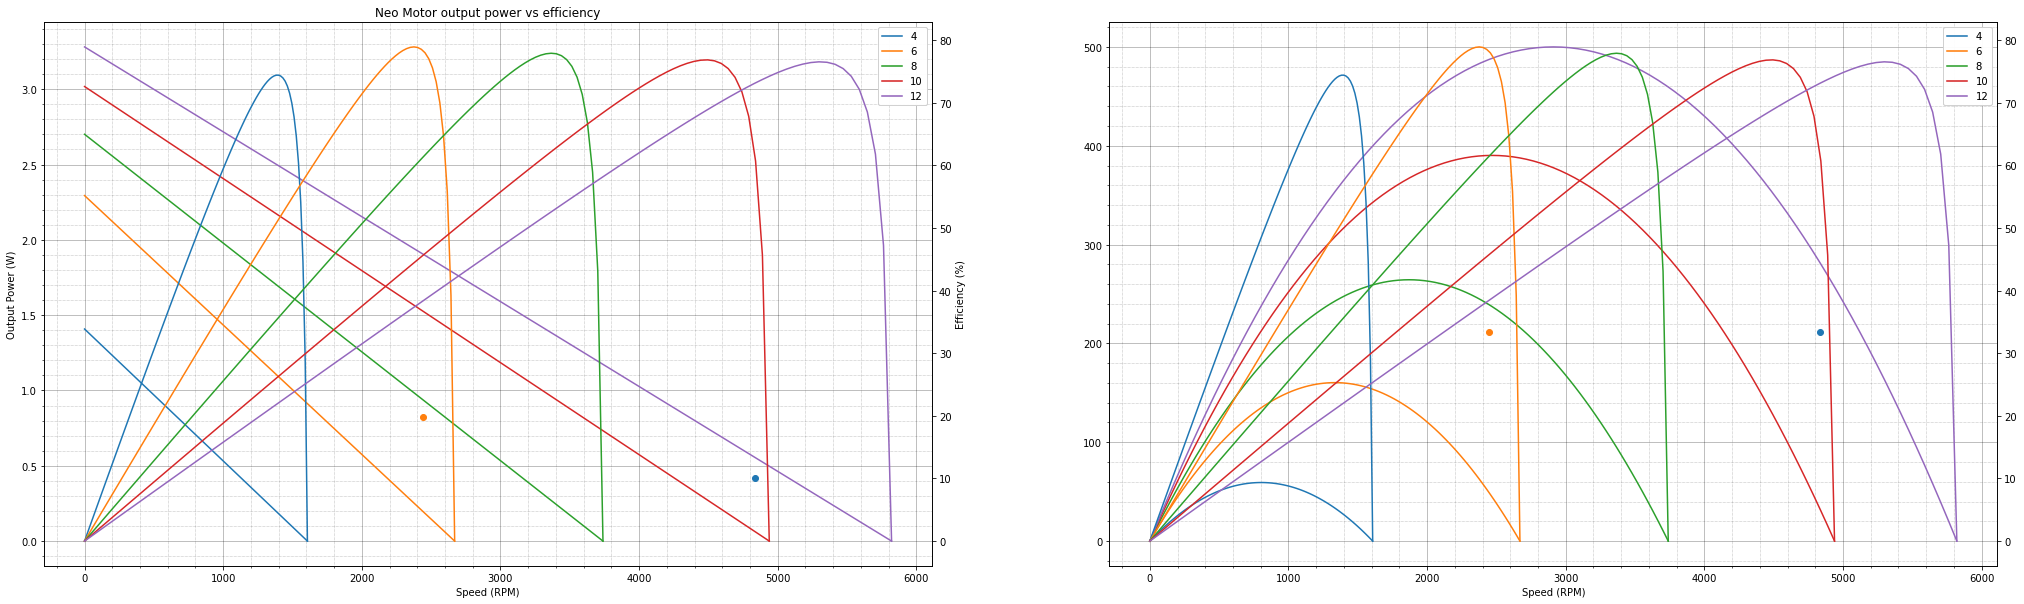

In [96]:
dataframes = []
for motor_name in ['neo']:
    for voltage in [4, 6, 8, 10, 12]:
        file_name = f'data/motor-curves/{motor_name}/MotorCurve-{voltage}V.csv'
        dataframe = pd.read_csv(file_name)
        dataframe['voltage'] = voltage
        dataframe['name'] = motor_name
        dataframes.append(dataframe)

neo_motor_curves = pd.concat(dataframes)
neo_motor_curves.set_index('Speed (RPM)', inplace=True)

fig, ax_group = plt.subplots(1, 2, figsize=(35, 10), sharex=False)

# unpack all the axes subplots
figures = ax_group.ravel()

fig1_eff = figures[0].twinx()
fig2_eff = figures[1].twinx()

figures[0].set_title('Neo Motor torgue vs efficiency')

figures[0].set_xlabel('Speed (RPM)')
figures[0].set_ylabel('Torque (Nm)')
fig1_eff.set_ylabel('Efficiency (%)')

#neo_motor_curves.set_index('Speed (RPM)', inplace=True)
neo_motor_curves.groupby('voltage')['Torque (Nm)'].plot(ax=figures[0], legend=True)
figures[0].set_axisbelow(True)
figures[0].minorticks_on()
figures[0].grid(which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
figures[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)
neo_motor_curves.groupby('voltage')['Efficiency (%)'].plot(ax=fig1_eff, legend=True)

figures[0].scatter(motor_geared_requirements['rotation speed (RPM)'][0], motor_geared_requirements['torque - geared (Nm)'][0], label='flat')
figures[0].scatter(motor_geared_requirements['rotation speed (RPM)'][1], motor_geared_requirements['torque - geared (Nm)'][1], label='slope')

figures[0].set_title('Neo Motor output power vs efficiency')

figures[0].set_xlabel('Speed (RPM)')
figures[0].set_ylabel('Output Power (W)')
fig1_eff.set_ylabel('Efficiency (%)')

neo_motor_curves.groupby('voltage')['Output Power (W)'].plot(ax=figures[1], legend=True)
figures[1].set_axisbelow(True)
figures[1].minorticks_on()
figures[1].grid(which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
figures[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)
neo_motor_curves.groupby('voltage')['Efficiency (%)'].plot(ax=fig2_eff, legend=True)

figures[1].scatter(motor_geared_requirements['rotation speed (RPM)'][0], motor_geared_requirements['power - geared (W)'][0], label='flat')
figures[1].scatter(motor_geared_requirements['rotation speed (RPM)'][1], motor_geared_requirements['power - geared (W)'][1], label='slope')


Torgue and stuff

Selection of motors

Steering motor sizing

#### Battery sizing

* Separate motor power from compute power

Notes:

* We need to be able to accelerate when going up the hill otherwise we can't get going
* Need to figure out what our maximum force can be on the ground before we slip (can we even go up the hill?)
* Work out the torgue levels for the motors for each wheel
* Work out the power levels for the motors for each wheel


Further:

* Rover inertia?
* Wheel inertia
* Steering power
* Braking power
* Pick-up of cargo
  * From sides without falling over
* FMEA -> Failure Mode Effects Cricicallity Analysis -> Try to predict failures before they happen
* stability
  * Stability while lifting / lowering


Design:

* Brakes + hold power for on the hill / when loading
* Suspension for individual wheels. At 4.0 m/s hitting anything will be nasty because the swing arms are large with heavy weights at the end (the wheels + motors)
* System redundancy
* Monitoring
* Wheel slip detection
* CAD -> Should inform:
  * Electrical
  * Centre of Gravity / Center of intertia etc
  * Structural
  * ROS / Gazebo
* Inspiration
  * SPMT - Self-propelled modular transporter: https://www.mammoet.com/equipment/transport/self-propelled-modular-transporter/spmt/


Software:

* Communication
  * Push
  * Pull
  * Pub / Sub
  * Pub to blackboard (only keep last value)
* Logs
* Telemetry
* Safe guards
  * Will need a shutdown
  * Load guards
  * Roll-over etc.
  * Human detection / Damage detection
  * Software security
    * Encryption
    * Trust roots
    * Access permissions
    * Audits
* Architecture
  * Layers
    * Hardware interaction
    * Processing
    * Goal level
  * Lower layers run constantly + interupts / blocks from high level (see: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.110.809&rep=rep1&type=pdf)
  * Middleware / Comms
* Configuration management -> Pushing new software versions, new commands etc.
  * Default way of pushing changes
  * Audit log
* Links
  * https://robops.org/manifesto
  

Electronics

* Modules
  * Processing
  * PID / Control
  * Batteries
* Eventually use busses for power / data so that we can replace bits
* Safety switches
  * Global
  * Local
  * Depower sections / whole rover
  * Depower motor circuits
  * Depower logic circuits

## Rover arm sizing